In [1]:
import cv2
import imutils as imu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def show(im, cmap=None):
    plt.imshow(im, cmap=cmap, interpolation="bilinear")

# Top-down view

In [2]:
def order_points(pts):
    ''' takes: pts: [4,2] matrix (list of 4 (x,y) pairs) 
        and returns: [4,2] matrix, ordered tl-tr-br-bl (x,y) pairs'''
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [3]:
def four_point_transform(im, pts):
    ''' takes: image and pts [4,2] matrix of (x,y) pairs in any order '''
    # obtain a consistent order of the points and unpack them individually
    org_pts = order_points(pts)
    (tl, tr, br, bl) = org_pts
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    btm_width = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    top_width = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(btm_width), int(top_width))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    right_height = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    left_height = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(right_height), int(left_height))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view"
    W, H = max_width-1, max_height-1
    dst_pts = np.array([
        [ 0 , 0 ], # top-left  corner
        [ W , 0 ], # top-right corner
        [ W , H ], # btm-right corner
        [ 0 , H ]  # btm-left  corner
    ], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform( org_pts, dst_pts )
    warped = cv2.warpPerspective( im, M, (max_width, max_height) )
    # return the warped image
    return warped

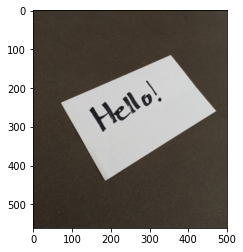

In [4]:
im = cv2.imread('utils/hello.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show(im)

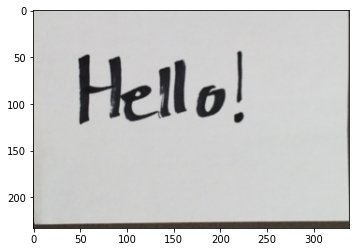

In [5]:
pts = np.array([(73, 239), (356, 117), (475, 265), (187, 443)])
r = four_point_transform(im, pts)
show(r)

# Edge detection

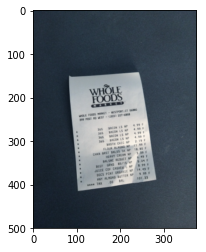

In [6]:
org_im = cv2.imread('utils/receipt.jpg')
ratio = org_im.shape[0] / 500
im = imu.resize(org_im, height = 500)
show(im)

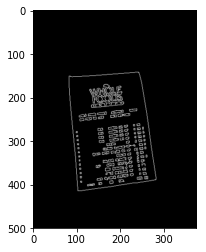

In [7]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.GaussianBlur(im, (5,5), 0)
minVal, maxVal, kernel_size = 75, 200, 3
edged = cv2.Canny(im, minVal, maxVal)#, kernel_size, L2gradient=False)
show(edged, cmap='gray')

In [8]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imu.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    screenCnt = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(screenCnt) == 4: break
print(screenCnt)

[[[241 142]]

 [[ 82 151]]

 [[102 414]]

 [[281 388]]]


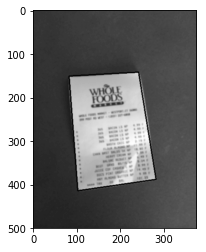

In [10]:
cv2.drawContours(im, [screenCnt], -1, (0, 255, 0), 2)
show(im, cmap='gray')

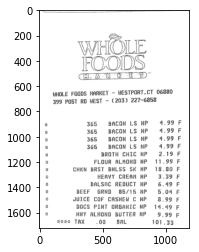

In [12]:
# apply the four point transform to obtain a top-down view of the original image
warped = four_point_transform(org_im, screenCnt.reshape(4,2) * ratio)
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
import skimage
T = skimage.filters.threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
show(warped, cmap='gray')